In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os

from pymystem3 import Mystem

import nltk
from nltk.tokenize import word_tokenize
from nltk import PorterStemmer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import random


Хорошая функция лемматизации (работает с русским языком - УРАААА), но нет предела совершенству - выполняется для 2000 отзывов 35 минут...

In [3]:

def Lemmatize(src: list):
    ''' Лемматизирует переданный датасет'''
    text_nomalized = ' '.join(src).lower() 

    m = Mystem()
    lemmas = m.lemmatize(text_nomalized)
    
    return lemmas

# Пункт 1

1. Необходимо загрузить исходный набор данных и соответствующие метки классов.

In [4]:
data = pd.read_csv('dataframe.csv')
data.head()

,class_mark,text_review
0,good,Зеленая миля\n'Они помогли ему убить себя и та...
1,good,"Зеленая миля\n'Боже, иногда Зеленая миля так д..."
2,good,Зеленая миля\nОни помогли ему убить себя\n\n«О...
3,good,Зеленая миля\n«Когда призовет Господь на свой ...
4,good,Зеленая миля\nОбвиненный в страшном преступлен...


Изменяем метки класса: если отзыв хороший, то записываем 1, иначе - 0

In [5]:
data.dropna(inplace=True)
change_labels = lambda x: 1 if x=='good' else 0
data['class_mark'] = data['class_mark'].apply(change_labels)
data.head()

,class_mark,text_review
0,1,Зеленая миля\n'Они помогли ему убить себя и та...
1,1,"Зеленая миля\n'Боже, иногда Зеленая миля так д..."
2,1,Зеленая миля\nОни помогли ему убить себя\n\n«О...
3,1,Зеленая миля\n«Когда призовет Господь на свой ...
4,1,Зеленая миля\nОбвиненный в страшном преступлен...


In [ ]:
# data.dropna(inplace=True)
remove_non_alphabets = lambda x: re.sub(r'[^а-яА-Я]',' ',str(x))

tokenize = lambda x: word_tokenize(x, language = "russian")

ps = PorterStemmer()
stem = lambda w: [ ps.stem(x) for x in w ]

print('remove_non_alphabets')
data['text_review'] = data['text_review'].apply(remove_non_alphabets)

print('tokenize')
data['text_review'] = data['text_review'].apply(tokenize) # [ word_tokenize(row) for row in data['email']]

print('stem')
data['text_review'] = data['text_review'].apply(stem)

print('Lemmatize')

c = 0
for i in data.index:
    data['text_review'][i] = Lemmatize(data['text_review'][i])
    data["text_review"][i] = [elem for elem in data["text_review"][i] if elem!=' ']
    c+=1

print('complete')

data.dropna(inplace=True)

data.head()



Чтобы каждый раз не ждать по 30 и более минут для лемматизации, создадим новый датафрейм с уже пролемматизированными словами

In [8]:
data.to_csv("new_dataframe.csv")

Заменим переменную data на новый датафрейм

In [9]:
data = pd.read_csv("new_dataframe.csv")

# Пункт 2

2. Произвести разделение загруженного набора данных на обучающую, тестовую и валидационую выборки (в соотношении 80:10:10). Проверить, что сформированные выборки сбалансированы.

In [19]:
data = pd.read_csv("new_dataframe.csv")
frac_seed = random.randint(0,10)
train_df = data.sample(frac=0.9, random_state=frac_seed, ignore_index=True)
valid_df = data.sample(frac=0.1, random_state=frac_seed, ignore_index=True)
for item in valid_df["text_review"]:
    while item in train_df['text_review']: 
        tmp = data.sample()
        item["text_review"] = tmp['text_review']
        item["class_mark"] = tmp["class_mark"]
     
train_df.to_csv("train_df.csv")
valid_df.to_csv("valid_df.csv")

# Пункты 3 и 4

3. Написать модель нейронной сети для решения задачи классификации.
4. Описать пайплайн предобработки данных. ВАЖНО: что так как ваш вариант предполагает работу с текстом, то необходимо выполниить векторизацию данных (подробности в туториале).

In [20]:
max_words = 10000
stopWords = stopwords.words('russian')

cv = CountVectorizer(max_features=max_words , stop_words=stopWords)

sparse_matrix = cv.fit_transform(train_df["text_review"]).toarray()
valid_sparse_matrix = cv.fit_transform(valid_df["text_review"]).toarray()
print(sparse_matrix.shape)
print(valid_sparse_matrix.shape)

x_val, x_test, y_val, y_test = train_test_split(
    valid_sparse_matrix, np.array(valid_df["class_mark"])
)

x_train, x_test, y_train, y_test = train_test_split(
    sparse_matrix, np.array(train_df["class_mark"]),test_size = 0.12, train_size= 0.88
)

(1800, 10000)
(200, 8909)


In [21]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear1 = nn.Linear(10000, 100)
        self.linear2 = nn.Linear(100, 10)
        self.linear3 = nn.Linear(10, 6)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

x_train = Variable(torch.from_numpy(x_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()

# Пункты 5 и 6

5. Написать train loop (цикл обучения). Провести эксперименты по обучению с различными значениями параметров learning rate (скорость обучения) и batch size (размер мини-пакета). Выбрать по 3 значения для learning rate и batch size (итоговое количество экспериментов будет 9).
6. Для каждого проведенного эксперимента вывести графики для значения функции потерь (ось x - итерация обучения/номер эпохи; ось y - значение функции потерь) и выбранной метрики качества (ось x - итерация обучения/номер эпохи; ось y - значение метрики качества). Графики необходимо выводить как для обучающей, так и для валидационной выборки.

In [47]:
def expirement(lr, batch_size):
    model = LogisticRegression()
    criterion = nn.CrossEntropyLoss()
    
    data = torch.utils.data.DataLoader(x_train, batch_size = batch_size)
    optimizer = torch.optim.Adam(params=model.parameters() , lr = lr)
    epochs = 10
    model.train()
    loss_values = []
    acc_values = list()
    
    for epoch in range(epochs):
        for elems in data: 
            
            optimizer.zero_grad()
            
            y_pred = model(x_train)
            
            
            loss = criterion(y_pred, y_train)
            loss_values.append(loss.item())
            pred = torch.max(y_pred, 1)[1].eq(y_train).sum()
            acc = pred * 100.0 / len(x_train)
            acc_values.append(acc)
            loss.backward()
            optimizer.step()
    
    epochs_values = list()
    for i in range(0,epochs): epochs_values.append(i)
    
    loss_values_graph = list()
    
    for i in range(0,len(loss_values), len(loss_values)//epochs):
        loss_values_graph.append(loss_values[i])
        
    acc_values_graph = list()
    
    for i in range(0,len(acc_values), len(acc_values)//epochs):
        acc_values_graph.append(acc_values[i])
        
    #print(loss_values_graph, epochs_values)
    
    plt.plot(epochs_values, loss_values_graph)
    plt.title('Таблица эпох и потерь при lr='+str(lr) +" batch_size="+str(batch_size))
    plt.xlabel('Эпоха',)
    plt.ylabel('Потери')
    plt.legend(['Потери'])
    plt.show()
    
    plt.plot(epochs_values, acc_values_graph, color = 'g')
    plt.title('Таблица эпох и качества при lr='+str(lr) +" batch_size="+str(batch_size))
    plt.xlabel('Эпоха',)
    plt.ylabel('Точность')
    plt.legend(['Точность'])
    plt.show()
    
    return model
    

       
    

Заполняем список моделей, где каждая модель возвращается функцией, которая принимает различные параметры learning rate  и batch size.

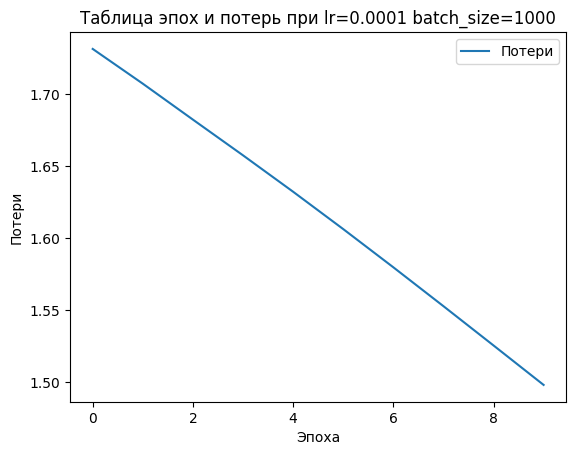

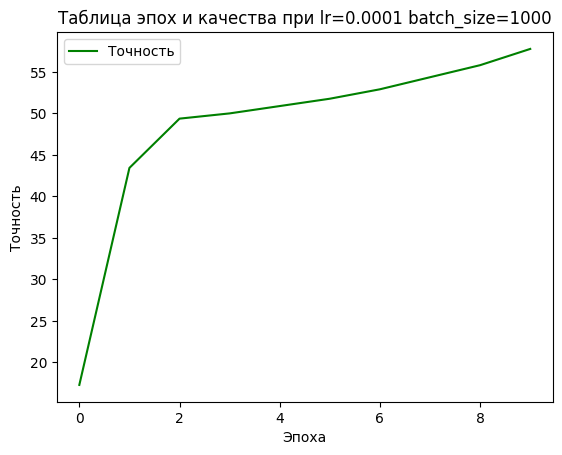

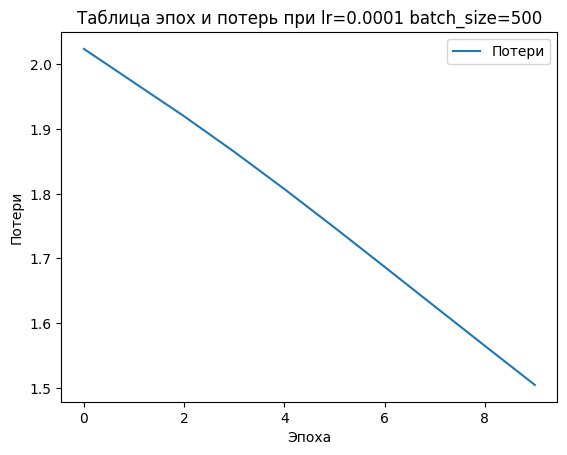

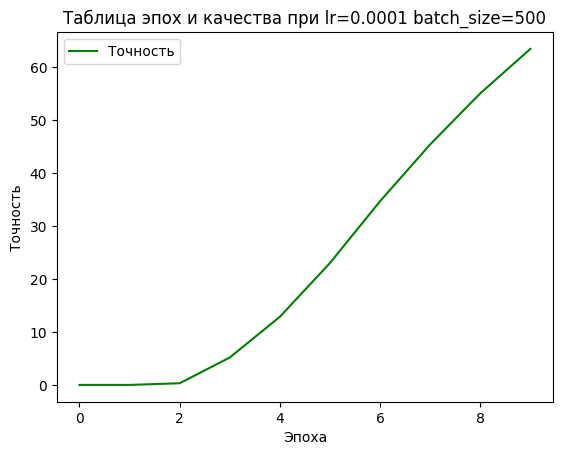

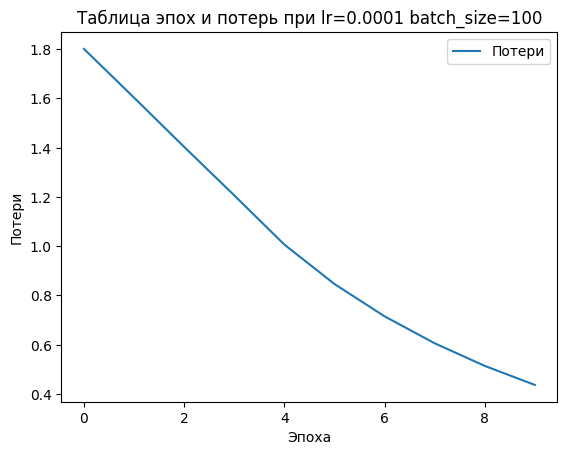

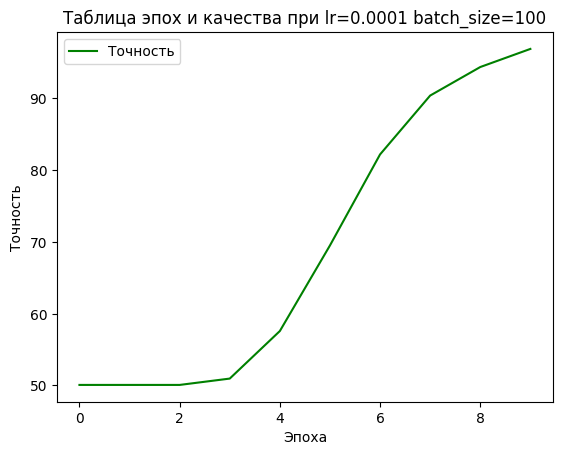

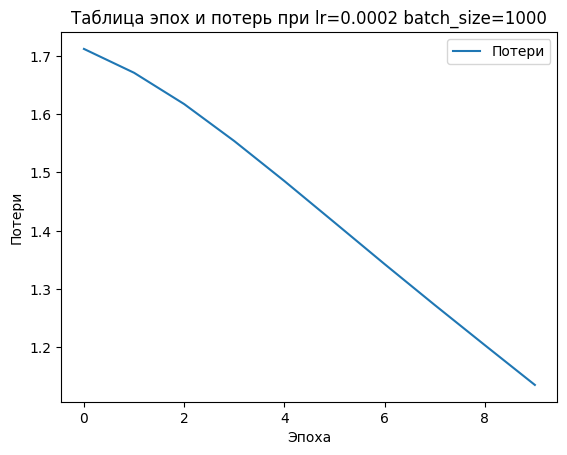

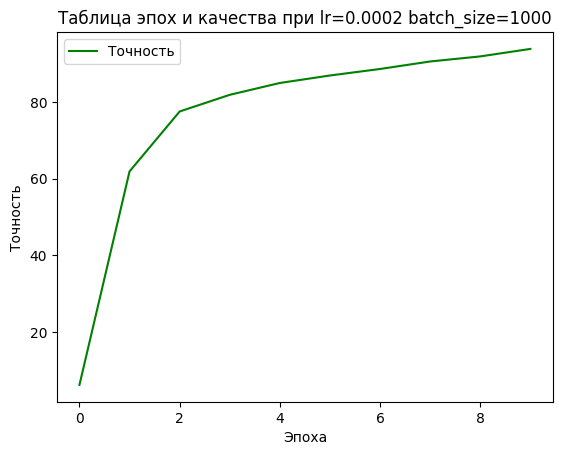

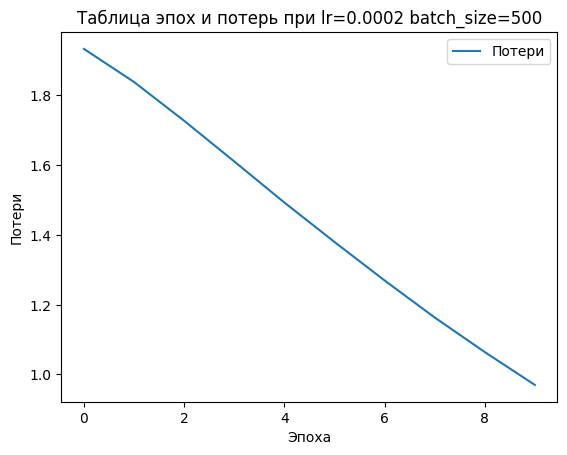

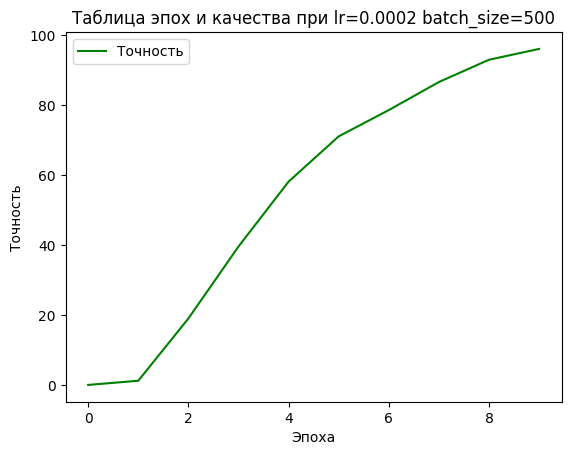

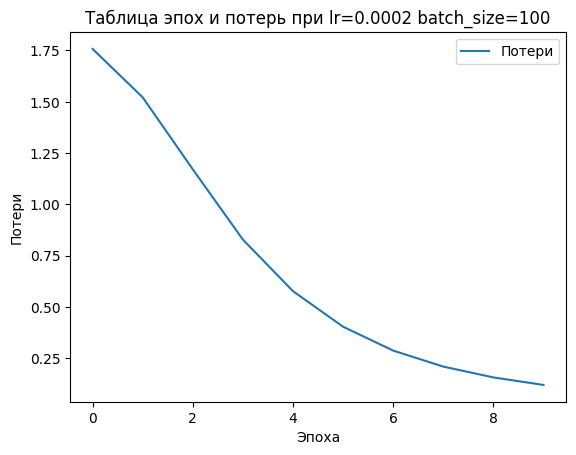

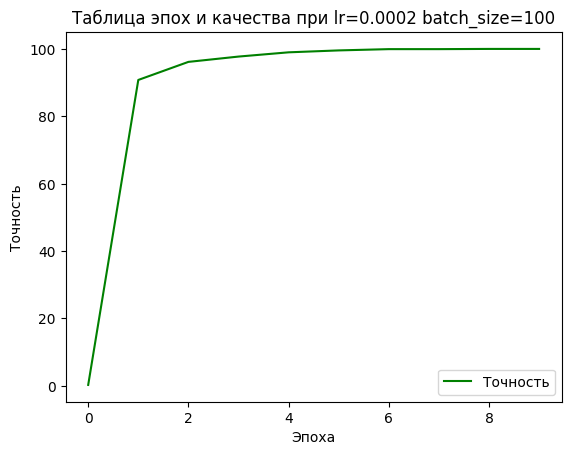

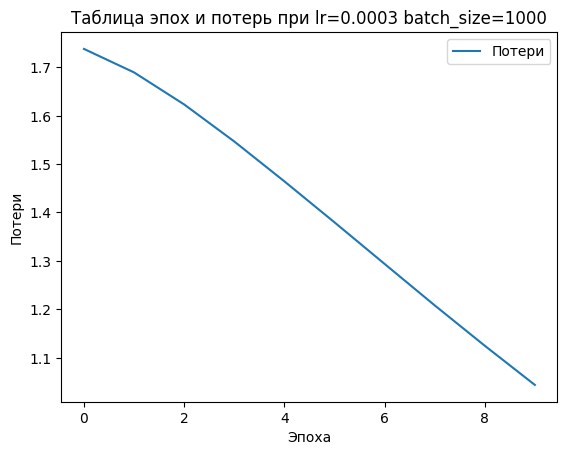

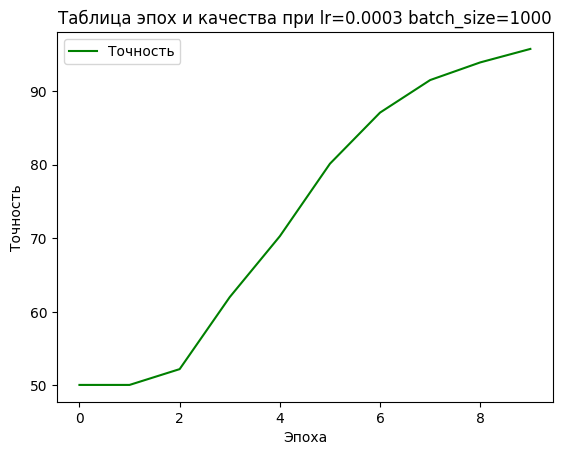

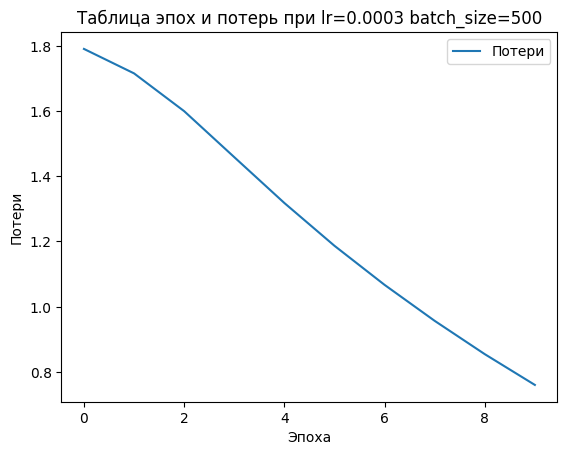

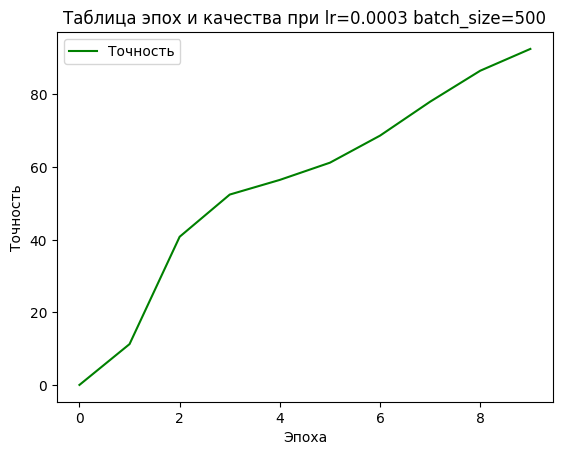

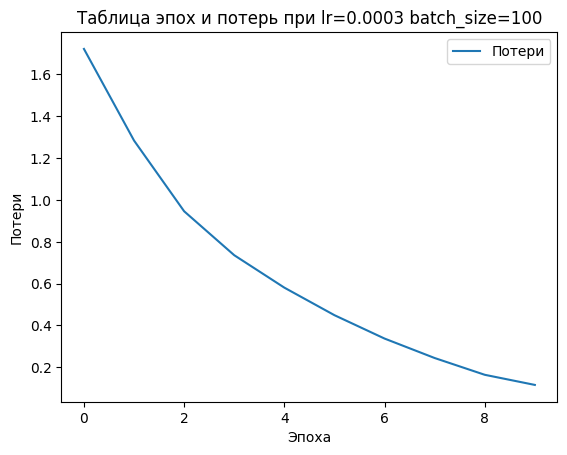

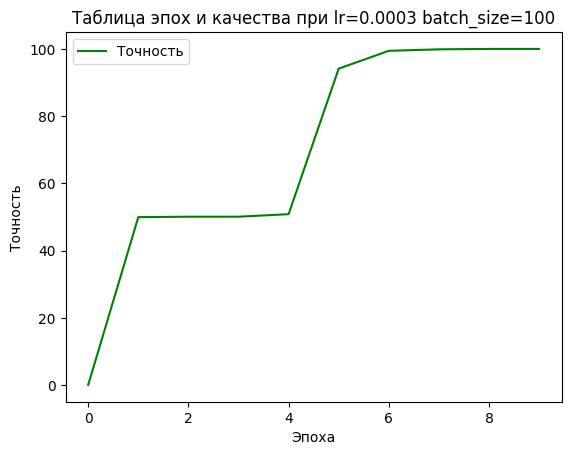

In [48]:
my_models = list()
lr_list=[0.0001,0.0002,0.0003]
batch_size=[1000,500,100]

for LR in lr_list:
        for BZ in batch_size:
            my_models.append(expirement(LR,BZ))

# Пункт 7

7. Оценить качество работы модели на тестовой выборке.

In [38]:
j = 1
lr_number = 0
bs_number = 0
acc_list = list()
for model in my_models:  
    criterion = nn.CrossEntropyLoss()  
    x_test = torch.Tensor(x_test).float()
    y_test=[int(i) for i in y_test]
    y_test = torch.Tensor(y_test).long()
    model.eval()
    with torch.no_grad():
        for i in range(100):
            y_pred = model(x_test)
            loss = criterion(y_pred, y_test)
            pred = torch.max(y_pred, 1)[1].eq(y_test).sum()
        acc = 100*pred/len(x_test)
        acc_list.append(acc)
        print ( "Number of model = ", j,"lr: ", lr_list[lr_number],"bs: ",batch_size[bs_number] ,
        " ----> Accuracy : {}%".format(100*pred/len(x_test)))
        bs_number += 1
        if j%3 == 0: 
            lr_number += 1
            bs_number = 0
        j +=1
print("Max acc: ", float(max(acc_list))  )      
       


Number of model =  1 lr:  0.0001 bs:  1000  ----> Accuracy : 47.685184478759766%
Number of model =  2 lr:  0.0001 bs:  500  ----> Accuracy : 77.31481170654297%
Number of model =  3 lr:  0.0001 bs:  100  ----> Accuracy : 97.68518829345703%
Number of model =  4 lr:  0.0002 bs:  1000  ----> Accuracy : 17.592592239379883%
Number of model =  5 lr:  0.0002 bs:  500  ----> Accuracy : 89.81481170654297%
Number of model =  6 lr:  0.0002 bs:  100  ----> Accuracy : 97.22222137451172%
Number of model =  7 lr:  0.0003 bs:  1000  ----> Accuracy : 52.314815521240234%
Number of model =  8 lr:  0.0003 bs:  500  ----> Accuracy : 90.27777862548828%
Number of model =  9 lr:  0.0003 bs:  100  ----> Accuracy : 97.68518829345703%
Max acc:  97.68518829345703


# Пункт 8

8. Сделайте выводы по полученным результатам проведенных экспериментов. Какую модель из всех полученных стоит использовать?

In [39]:
LR = 0.0003
BZ = 100

# Пункт 9

9. Сохранить обученную модель.

In [40]:

i = 0
for model in my_models:
    torch.save(model.state_dict(), os.path.join("./", f"model{i}.pt"))
    i+=1

# Пункт 10

In [46]:

model.load_state_dict(torch.load(os.path.join("./", "model8.pt")))
data=torch.utils.data.DataLoader(x_test, batch_size=BZ,shuffle=True)
model.eval()
text_list=[]
with torch.no_grad():
    for i in range(100):
        y_pred = model(x_test)
        loss = criterion(y_pred, y_test)
        pred = torch.max(y_pred, 1)[1].eq(y_test).sum()
    print ("Accuracy : {}%".format(100*pred/len(x_test)))


Accuracy : 97.68518829345703%
